In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## Trying out multiple trajectories with Russ's example code and Pendulum env

In [7]:
from __future__ import print_function, absolute_import
import matplotlib.pyplot as plt
import numpy as np

from multiple_traj_opt import (
    make_mto,
    MultipleTrajOpt,
    initial_conditions_Russ,
    initial_conditions_grid,
    initial_conditions_random,
)
from nn_system.networks import *

class FCBIG(nn.Module):
    def __init__(self, n_inputs=4, h_sz=8):
        super(FCBIG, self).__init__()
        self.n_inputs = n_inputs
        self.fc2 = nn.Linear(self.n_inputs, h_sz)
        self.fc3 = nn.Linear(h_sz, 1)

    def forward(self, x):
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def make_mto_manual():
    ###############################################
    # Construct the initial MathematicalProgram
    ###############################################
    num_trajectories = 16
    num_samples      = 16
    kMinimumTimeStep = 0.2
    kMaximumTimeStep = 0.5

    # ic_list = None
    # ic_list = [(0., 0.)]
    # ic_list = np.array([(0. + .1*ti, 0.0) for ti in range(num_trajectories)])
    ic_list = initial_conditions_grid(num_trajectories)

    # seed = 1776
    # seed = None
    # seed = np.random.randint(0, 2000); print("seed: {}".format(seed))
    seed = 1338
    mto = MultipleTrajOpt("pendulum",
                          num_trajectories, 
                          num_samples,
                          kMinimumTimeStep,
                          kMaximumTimeStep,
                          ic_list=ic_list,
                          warm_start=False,
                          seed=seed)


    ###############################################
    # Add a neural network!
    ###############################################
    # kNetConstructor = None
    # kNetConstructor = lambda: FC(2)
#     kNetConstructor = lambda: FCBIG(2)
    # kNetConstructor = lambda: MLPSMALL(2)
    # kNetConstructor = lambda: MLP(2)
    kNetConstructor = lambda: FCBIG(2, 32)

    reg_type = "No"
    # reg_type = "L1"
    # reg_type = "L2"
    if kNetConstructor is not None:
        mto.add_nn_params(kNetConstructor,
                          use_constraint    = True,
                          cost_factor       = None,
                          initialize_params = True, 
                          reg_type          = reg_type)

    # Introduce a scaling factor in (0, 1] that can be used to shrink the initial
    # conditions regions used for policy rollouts, so we can check an area SMALLER
    # than that which was used for dircol calculations!
    scaling = 0.5
    # mto.add_multiple_trajectories_visualization_callback(vis_ic_list=None)
    mto.add_multiple_trajectories_visualization_callback(11, vis_ic_list=[])
    mto.add_cost_and_constraint_printing_callback(1)

    
    # Add in some SNOPT settings changes here!!!
    # Looks like we are getting good enough solutions!!!
    from pydrake.all import (SolverType)
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'Verify level', -1)
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Print file', "/tmp/snopt.out")

#     mto.prog.SetSolverOption(SolverType.kSnopt, 'Major feasibility tolerance', 2.0e-2) # default="1.0e-6"
#     mto.prog.SetSolverOption(SolverType.kSnopt, 'Major optimality tolerance',  2.0e-2) # default="1.0e-6"
#     mto.prog.SetSolverOption(SolverType.kSnopt, 'Minor feasibility tolerance', 2.0e-3) # default="1.0e-6"
#     mto.prog.SetSolverOption(SolverType.kSnopt, 'Minor optimality tolerance',  2.0e-3) # default="1.0e-6"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Major feasibility tolerance', 1.0e-6) # default="1.0e-6"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Major optimality tolerance',  1.0e-6) # default="1.0e-6"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Minor feasibility tolerance', 1.0e-6) # default="1.0e-6"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Minor optimality tolerance',  1.0e-6) # default="1.0e-6"

    # Lower if nonlinear constraint are cheap to evaluate, else higher...
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'Linesearch tolerance',  0.9) # default="0.9"

    mto.prog.SetSolverOption(SolverType.kSnopt, 'Major step limit',  0.1) # default="2.0e+0"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Time limit (secs)',  120.0) # default="9999999.0"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Reduced Hessian dimension',  10000) # Default="min{2000, n1 + 1}"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Hessian updates',  30) # Default="10"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Major iterations limit',  9300000) # Default="9300"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Minor iterations limit',  50000) # Default="500"
    mto.prog.SetSolverOption(SolverType.kSnopt, 'Iterations limit',  50*10000) # Default="10000"

    # mto.prog.SetSolverOption(SolverType.kSnopt, 'New superbasics limit',  99) # Default="99"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'Violation limit',  10.0) # Default="10.0"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'Superbasics limit',  5000) # Default="n1 + 1"


    # LUSOL Factorization options
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'LU factor tolerance', 3.99) # Default ="3.99"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'LU update tolerance', 3.99) # Default ="3.99"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'LU singularity tolerance', 3.2e-11) # Default ="3.2e-11"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'LU partial pivoting', True) # Default="*partial/rook/complete"

    # mto.prog.SetSolverOption(SolverType.kSnopt, 'Derivative linesearch', True) # Default="*Derivative/Nonderivative"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'Nonderivative linesearch', True) # Default="*Derivative/Nonderivative"

    # Factoriztion?
    mto.prog.SetSolverOption(SolverType.kSnopt, 'QPSolver Cholesky', True) # Default="*Cholesky/CG/QN"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'QPSolver CG', True) # Default="*Cholesky/CG/QN"
    # mto.prog.SetSolverOption(SolverType.kSnopt, 'QPSolver QN', True) # Default="*Cholesky/CG/QN"

    return mto

In [19]:
# Solve the mto once initialially
mto = make_mto(kNetConstructor=lambda: FCBIG(2, 32), use_constraint=False, cost_factor=10.,
              vis_cb_every_nth=10, cost_cb_every_nth=10, snopt_overrides=[('Time limit (secs)',  600.0)])
mto.Solve()

Overrode Time limit (secs) = 600.0
 0total cost:  539.35 | 	constraint  4435.40 	bad 240,  4292.69
 1 2 3 4 5 6 7 8 9 10total cost:  18582.14 | 	constraint  3411.82 	bad 240,  3163.56
 11 12 13 14 15 16 17 18 19 20total cost:  14891.38 | 	constraint  523.95 	bad 0,  0.00
 21 22 23 24 25 26 27 28 29 30total cost:  10442.83 | 	constraint  520.12 	bad 0,  0.00
 31 32 33 34 35 36 37 38 39 40total cost:  7585.57 | 	constraint  509.80 	bad 0,  0.00
 41 42 43 44 45 46 47 48 49 50total cost:  7099.24 | 	constraint  501.46 	bad 0,  0.00
 51 52 53 54 55 56 57 58 59 60total cost:  6054.02 | 	constraint  471.90 	bad 0,  0.00
 61 62 63 64 65 66 67 68 69 70total cost:  5577.26 | 	constraint  452.08 	bad 0,  0.00
 71 72 73 74 75 76 77 78 79 80total cost:  5400.04 | 	constraint  446.07 	bad 0,  0.00
 81 82 83 84 85 86 87 88 89 90total cost:  5071.87 | 	constraint  433.82 	bad 0,  0.00
 91 92 93 94 95 96 97 98 99 100total cost:  4834.75 | 	constraint  417.03 	bad 0,  0.00
 101 102 103 104 105 106 107 1

 851 852 853 854 855 856 857 858 859 860total cost:  2567.61 | 	constraint  326.60 	bad 0,  0.00
 861 862 863 864 865 866 867 868 869 870total cost:  2566.59 | 	constraint  326.51 	bad 0,  0.00
 871 872 873 874 875 876 877 878 879 880total cost:  2565.12 | 	constraint  326.30 	bad 0,  0.00
 881 882 883 884 885 886 887 888 889 890total cost:  2562.81 | 	constraint  326.08 	bad 0,  0.00
 891 892 893 894 895 896 897 898 899 900total cost:  2560.86 | 	constraint  326.03 	bad 0,  0.00
 901 902 903 904 905 906 907 908 909 910total cost:  2559.85 | 	constraint  325.92 	bad 0,  0.00
 911 912 913 914 915 916 917 918 919 920total cost:  2559.00 | 	constraint  325.90 	bad 0,  0.00
 921 922 923 924 925 926 927 928 929 930total cost:  2558.50 | 	constraint  325.88 	bad 0,  0.00
 931 932 933 934 935 936 937 938 939 940total cost:  2557.93 | 	constraint  325.83 	bad 0,  0.00
 941 942 943 944 945 946 947 948 949 950total cost:  2556.58 | 	constraint  325.82 	bad 0,  0.00
 951 952 953 954 955 956 957 9

SolutionResult.kUnknownError

In [ ]:
# 1) SIMPLE RESTART WITH POTENTIALLY DIFFERENT SETTINGS, full huxT
# Then resolve again with (potentially different settings, but using the previous answer as a warm start)
old_mto = mto
mto = make_mto()

# Warm start...
old_mto_dec_vals = old_mto.prog.GetSolution(old_mto.prog.decision_variables())
mto.prog.SetInitialGuessForAllVariables(old_mto_dec_vals)

mto.Solve()

[0, 0, 0]


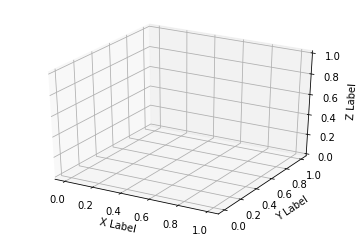

In [23]:
# Let's plot all the u's on the z axis and x (theta, theta_dot) on the y and x axes...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = [], [], []
for ti in range(new_mto.num_trajectories):
    h_sol  = new_mto.prog.GetSolution(new_mto.h[ti])[0]
    print(h_sol)

    t_s = [h_sol*i for i in range(new_mto.num_samples)]
    x_s  = new_mto.prog.GetSolution(new_mto.x[ti])
    u_s    = new_mto.prog.GetSolution(new_mto.u[ti])
    x_trajectory = PiecewisePolynomial.Cubic(t_s, x_s, False)
#     t_samples = np.linspace(breaks[0], breaks[-1], 100) 
#     x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])
    thetas, theta_dots = zip(*x_s)
    print(thetas, theta_dots, u_s)
    xs += thetas
    ys += theta_dots
    zs += u_s
print(list((len(thing) for thing in (xs, ys, zs))))
ax.scatter(xs, ys, zs, c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<IPython.core.display.Javascript object>


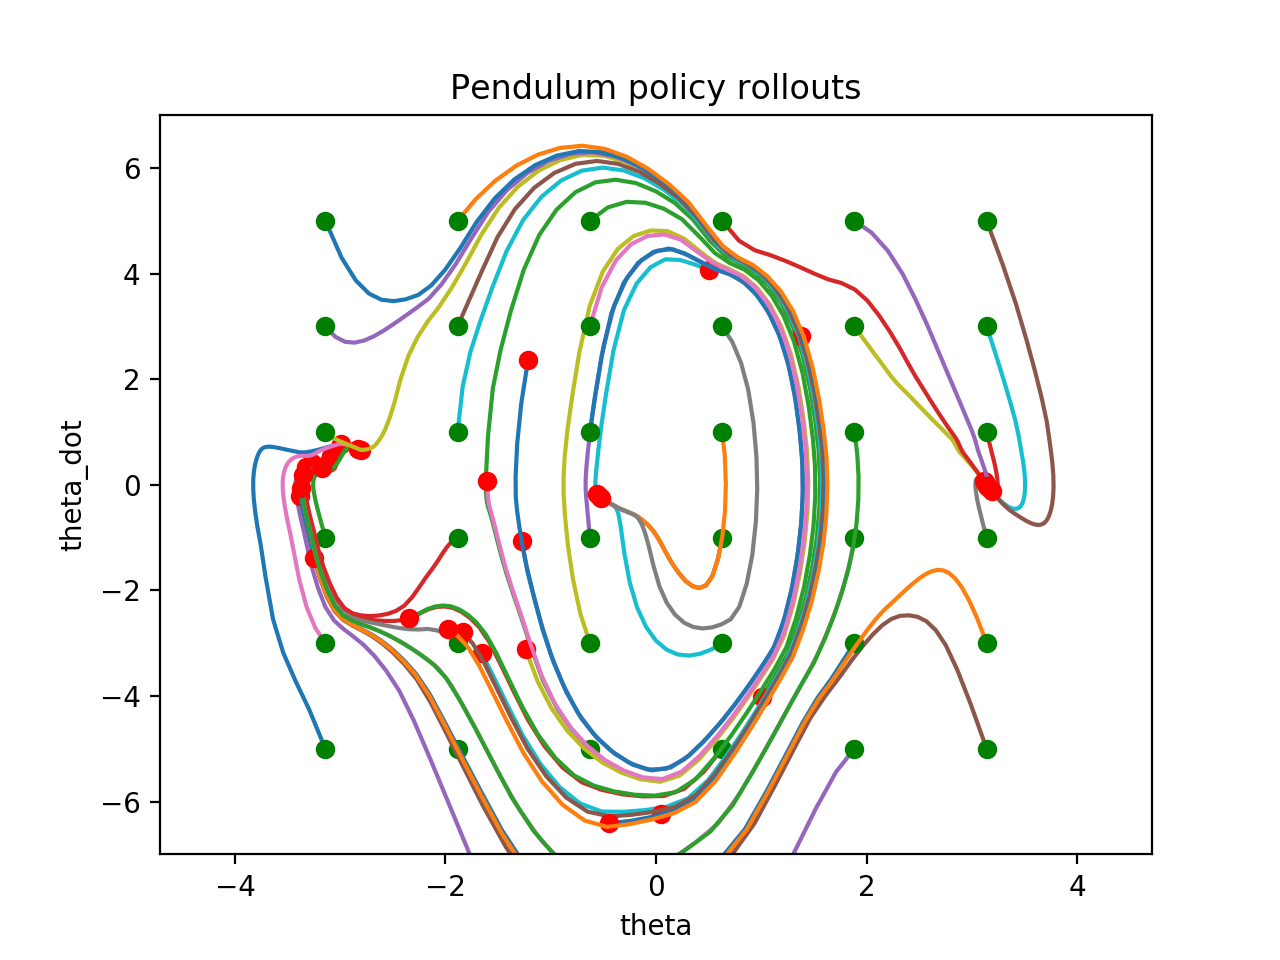

In [21]:
import math
ic_list = initial_conditions_grid(36, (-math.pi, math.pi), (-5, 5))
mto.plot_all_policies("state_scatter", ic_list)

In [14]:
from nn_system.NNSystemHelper import create_nn
kNetConstructor = lambda: FCBIG(2)
nn = create_nn(kNetConstructor, list(new_mto.prog.GetSolution(new_mto.T)))
list(nn.parameters())

[Parameter containing:
 tensor([[-3.3512e+00, -2.3359e-01],
         [ 4.2580e-01, -8.2241e-01],
         [-1.3982e+01,  2.0918e+00],
         [-1.2608e+01, -1.2959e+00],
         [-2.6963e-01,  2.3004e-02],
         [-2.1693e-01, -1.0048e-02],
         [-1.0597e+00,  8.1029e-02],
         [-1.1104e+01,  1.7718e+00]], requires_grad=True),
 Parameter containing:
 tensor([ 0.8590, -4.2683,  1.7292,  3.3363, -0.6764, -1.1124, -4.1258,  1.4944],
        requires_grad=True),
 Parameter containing:
 tensor([[ 6.2567,  2.4862, -5.3782, -1.2467, -0.2494,  0.1697, -1.6101,  6.2733]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.4968], requires_grad=True)]

In [30]:
ti = 0
mto.render_policy(ti)

<IPython.core.display.Javascript object>


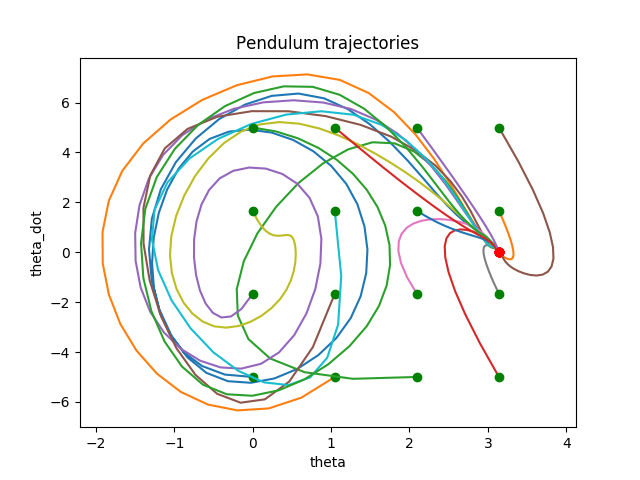

In [14]:
mto.plot_all_trajectories("state_scatter")
# mto.plot_all_trajectories("state_quiver")
# mto.plot_all_trajectories("tip_scatter")
# mto.plot_all_trajectories("tip_quiver")

### Visualize the found trajectories

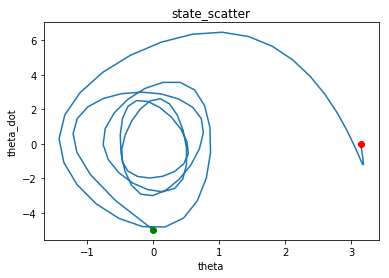

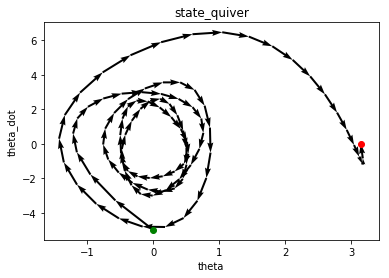

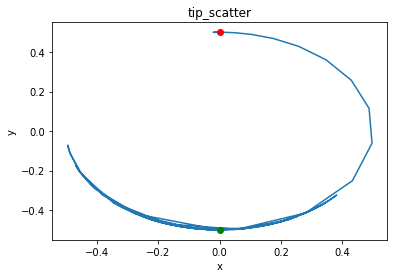

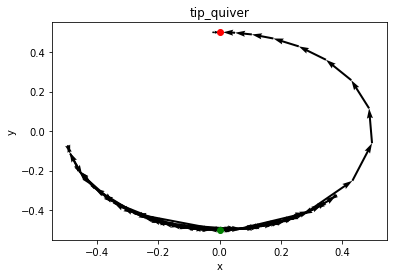

In [19]:
ti = 0
mto.plot_single_trajectory(ti, "state_scatter")
mto.plot_single_trajectory(ti, "state_quiver")
mto.plot_single_trajectory(ti, "tip_scatter")
mto.plot_single_trajectory(ti, "tip_quiver")

mto.render_single_trajectory(ti)